In [46]:
import cvxpy as cp
from ortools.sat.python import cp_model

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

### LOAD DATA

Be careful, to work more easily with array index, we decrease each number_brick index and number_saler_index by 1

In [48]:
# Load distance dataset 
# Brick to SR office distances 
initial_D = pd.read_excel("../data/distances.xlsx", sheet_name="brick-bureau",\
                                        skiprows=1, usecols="C:F").values

# Brick to brick distances 
initial_B = pd.read_excel("../data/distances.xlsx", sheet_name="brick-brick",\
                                      skiprows=1, usecols="C:X").values

num_bricks = initial_D.shape[0]
num_SR = initial_D.shape[1]

print("Brick numbers :", num_bricks)
print("SR numbers :", num_SR)

Brick numbers : 22
SR numbers : 4


In [49]:
#Define previous structure of sales territories
structure = pd.DataFrame(columns=["SR", "Center-brick", "Previous_Bricks"])
structure["SR"] = [1, 2, 3, 4]
structure["Center-brick"] = [4,14,16,22]
structure["Previous_Bricks"] = [[4, 5, 6, 7, 8, 15],\
                               [10, 11, 12, 13, 14],\
                               [9, 16, 17, 18],\
                               [1, 2, 3, 19, 20, 21, 22]]

# P is our assignement matrix
P = np.zeros((num_bricks, num_SR), dtype=int)
for j in range(num_SR):
    bricks_of_SR_j = structure.loc[j, "Previous_Bricks"]
    for i in bricks_of_SR_j:
        P[i-1][j] = 1  # i-1 because we decrease each bricks index number by 1 

structure

,SR,Center-brick,Previous_Bricks
0,1,4,"[4, 5, 6, 7, 8, 15]"
1,2,14,"[10, 11, 12, 13, 14]"
2,3,16,"[9, 16, 17, 18]"
3,4,22,"[1, 2, 3, 19, 20, 21, 22]"


In [50]:
#Define brick values : V 
initial_V = np.array([0.1609, 0.1164, 0.1026, 0.1516, 0.0939, 0.1320, 0.0687,\
              0.0930, 0.2116, 0.2529, 0.0868, 0.0828, 0.0975, 0.8177,\
              0.4115, 0.3795, 0.0710, 0.0427, 0.1043, 0.0997, 0.1698,\
              0.2531])

### UTILS  

In [51]:
def generate_problem(P, D, V, relaxation=False, new_SR=False):
    """
    generate the problem for cvxpy solver 
    P : previous assignement 
    D : distance between SR office and block
    V : value of each block
    relaxation : use True if you want to remove binary constraint (for question 4)
    new_SR : use True if you have a new_SR (for question 5). If true, new_SR distance 
        need to be concatenated at the right of current D matrix

    return cvxpy problem 
    """
    num_bricks = D.shape[0]
    num_SR = D.shape[1]
    # VARIABLES 
    if relaxation:
        # In relaxation Xij = % of brick i assigned to SR j 
        X = cp.Variable((num_bricks, num_SR), name="X")
        X_constraint = [X >= 0]
    else:    
        # Xij = 1 if brick i in assigned to SR j 
        # 0 else 
        X = cp.Variable((num_bricks, num_SR), name="X", boolean=True)
        X_constraint = []
 
    # PARAMETERS
    min_load = cp.Parameter(name="min_load")
    max_load = cp.Parameter(name="max_load")
    disrup_up_bound = cp.Parameter(name="disrup_up_bound")
    
    # CONSTRAINTS
    # Assignement : each block is assigned to one and only one SR
    # => Sum over j Xij = 1 
    assigment_constraint = [cp.sum(X, axis=1) == np.ones((num_bricks,))]

    # Workload objective is handle as a constraint : 
    # for each Sr j, min_load <= Sum over i of  Vi * Xij  <= max_load
    min_load = np.ones((1, num_SR)) * min_load
    max_load = np.ones((1, num_SR)) * max_load
    load_charge = V.reshape((1,-1)) @ X
    workload_constraint = [load_charge >= min_load, load_charge <= max_load]

    # Disruption objective is also handle as a constrant :
    # Sum over i,j  of Vi * abs(Xij - Pij) /2 <= upper_bound
    if not new_SR:
        disruption = cp.sum(V.reshape((1,-1)) @ cp.abs(X - P))
    else:
        disruption = cp.sum(V.reshape((1,-1)) @ cp.abs(X[:,:-1] - P))

    disruption_constraint = [disruption <= disrup_up_bound]

    # OBJECTIVE
    # Distance : Minimize Sum over i,j  of Dij * Xij  
    distance = cp.sum(cp.diag(D.T @ X))
    epsilon = 0.001
    objective = cp.Minimize(distance + epsilon * disruption)

    # PROBLEM DEFINITION
    constraints = assigment_constraint + workload_constraint + disruption_constraint + X_constraint
    problem = cp.Problem(objective, constraints)
    
    return problem

In [52]:
def compute_distance(X,D):
    """
    Return the distance each SR has to compute given affectation X
    = dist SRj = sum over i, Dij * Xij 
    """
    num_SR = D.shape[1]
    return np.array([D[:,j] @ X[:,j] for j in range(num_SR)])

def compute_total_distance(X,D):
    return np.sum(compute_distance(X,D))

In [53]:
def compute_workload(X,V):
    """
    Return the workload of each SR j 
    = sum over i, Vi * Xij 
    """
    return V @ X

def compute_total_workload(X,V):
    return np.sum(compute_workload(X,V))

In [54]:
def compute_disruption(X, V, new_SR=False):
    """
    Return disruption for each SR j
    = sum over i, Vi * Abs(X-P)i,j 
    """
    if not new_SR:
        return V @ np.abs(X-P)
    else:
        return V @ np.abs(X[:,:-1]-P)
    
def compute_total_disruption(X, V, new_SR=False):
    return np.sum(compute_disruption(X, V, new_SR))

In [55]:
def solution_to_dataframe(X,D,V):
    """
    Transform an assignement matrix X 
    into a easily understandable dataframe
    """
    num_bricks = D.shape[0]
    num_SR = D.shape[1]
    
    solution = pd.DataFrame(columns=["SR", "Center-brick", "Bricks", \
                                   "Disruption", "Workload", "Distance"])
    solution[["SR", "Center-brick"]] = structure[["SR", "Center-brick"]]

    solution["Bricks"] = [[] for _ in range(num_SR)]
    for i in range(num_bricks):
        for j in range(num_SR):
            if X[i][j] == 1:
                solution.loc[j, "Bricks"].append(i+1) # i+1 because now we get back to normal index

    solution["Disruption"] = compute_disruption(X,V)
    solution["Workload"] = compute_workload(X,V)
    solution["Distance"] = compute_distance(X,D)

    return solution

In [56]:
def find_all_efficient_solutions(problem, min_load, max_load, V=initial_V, \
                                 solver=None, epsilon = 0.001, new_SR=False):
    """
    Arg :
        problem : cvxpy problem object
        min_load, max_load : bound for workload constraint 
        V : value matrix 
        solver : can specify a specific solver
        epsilon : use to tune the number of efficient solution that is output
        new_SR : true if you want to consider a new_SR 
        
    Return all the efficient solution as a list of assignment matrix 
    """
    disruption_upper_bound = 1000
    list_of_solutions = []
    is_feasible = True
    problem.parameters()[0].value = min_load
    problem.parameters()[1].value = max_load
    problem.parameters()[2].value = disruption_upper_bound
    
    number_solutions = 1
    print("number_solutions =", end=" ")

    while is_feasible:
        problem.parameters()[2].value = disruption_upper_bound
        try:  # Because it seems that some solver raise an exception when infeasible, some don't ...
            problem.solve(solver=solver)
            if problem.status not in ["infeasible", "unbounded"] :
                print(number_solutions, end=" ")
                X = problem.variables()[0].value
                list_of_solutions.append(X)
                disruption_upper_bound = compute_total_disruption(X, V, new_SR) - epsilon
            else:
                break
        except:
            break
        number_solutions += 1

    print()
    return list_of_solutions

In [154]:
def plot_solutions(list_of_solutions, D, V=initial_V, new_SR=False):
    """
    Arg
        list_of_solutions : list of assignment matrix 
        D : distance brick - SR matrix
        V : value of each brick
        new_SR : true if you consider a new SR 
        
    Plot all the solution on a 2D-figure (disruption vs distance)
    """
    plot_df = pd.DataFrame(columns=["Disruption", "Distance"])
    plot_df["Disruption"] = list(map(lambda x: compute_total_disruption(x, V, new_SR), list_of_solutions))
    plot_df["Distance"] = list(map(lambda x : compute_total_distance(x,D), list_of_solutions))

    sns.scatterplot(x="Distance", y="Disruption", data=plot_df)

### QUESTION 1 AND 2 

In [58]:
# Print the initial solution
# We note that the workload constraint is not okay for the initial solution 
solution_to_dataframe(P, initial_D, initial_V)

,SR,Center-brick,Bricks,Disruption,Workload,Distance
0,1,4,"[4, 5, 6, 7, 8, 15]",0.0,0.9507,19.30
1,2,14,"[10, 11, 12, 13, 14]",0.0,1.3377,33.32
2,3,16,"[9, 16, 17, 18]",0.0,0.7048,10.05
3,4,22,"[1, 2, 3, 19, 20, 21, 22]",0.0,1.0068,124.74


In [59]:
problem = generate_problem(P, initial_D, initial_V)

In [60]:
list_of_solutions_Q1 = find_all_efficient_solutions(problem, solver=cp.GLPK_MI,min_load=0.8, max_load=1.2)
list_of_dataframes = list(map(lambda x: solution_to_dataframe(x,initial_D,initial_V), list_of_solutions_Q1))
list_of_dataframes[0]

number_solutions = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 


,SR,Center-brick,Bricks,Disruption,Workload,Distance
0,1,4,"[4, 5, 6, 7, 8, 9, 12, 19, 20]",0.9099,1.0376,64.37
1,2,14,"[11, 13, 14, 18]",0.3784,1.0447,7.53
2,3,16,"[10, 15, 16, 17]",0.9187,1.1149,6.57
3,4,22,"[1, 2, 3, 21, 22]",0.2040,0.8028,76.13


Plot the solutions : orange dot = current assignment

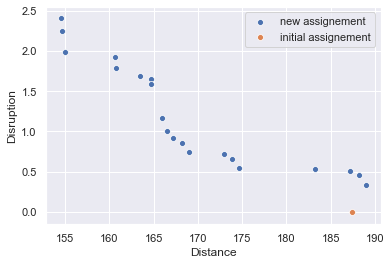

In [61]:
plot_solutions(list_of_solutions_Q1, initial_D)
sns.scatterplot([compute_total_distance(P,initial_D)], [compute_total_disruption(P,initial_V)])
plt.legend(["new assignement", "initial assignement"])


QUESTION 3

number_solutions = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
number_solutions = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
number_solutions = 1 2 3 4 5 6 7 8 9 10 11 12 
number_solutions = 1 2 3 4 5 6 7 8 9 10 11 
number_solutions = 1 2 3 4 5 6 7 8 9 10 


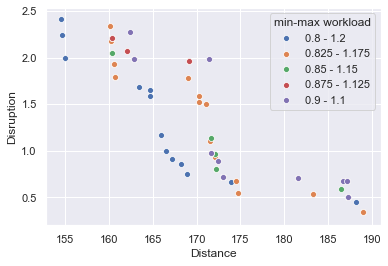

In [65]:
nb_step = 5
min_workload = np.linspace(0.8, 0.9, nb_step).round(3)
max_workload = np.linspace(1.2, 1.1, nb_step).round(3)
list_of_legend = [str(min_workload[i]) + " - " + str(max_workload[i]) \
                  for i in range(nb_step)]
list_of_list_solutions = []
for i in range(nb_step):
    list_of_solutions = find_all_efficient_solutions(problem, min_load=min_workload[i],\
                                                     max_load=max_workload[i])
    list_of_list_solutions.append(list_of_solutions)
    plot_solutions(list_of_solutions, initial_D)
    plt.legend(list_of_legend, title="min-max workload")

QUESTION 4

In [63]:
relaxed_problem = generate_problem(P,initial_D,initial_V, relaxation=True)

In [64]:
list_of_relax_solutions = find_all_efficient_solutions(relaxed_problem, min_load=0.8,\
                                                 max_load=1.2, solver=cp.GLPK, epsilon=0.05)
# NEED TO TAKE AN OTHER SOLVER 

number_solutions = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 


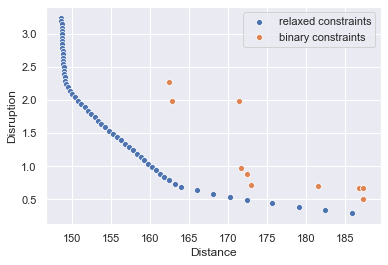

In [24]:
plot_solutions(list_of_relax_solutions, initial_D) # list of efficient solutions without binary constraint
plot_solutions(list_of_solutions, initial_D) # list of efficient solutions with binary constraint
plt.legend(["relaxed constraints", "binary constraints"])

### Question 5) 
On this approach, we will : 
- find all efficient solutions for each possible location of the new SR
- from this list of list of solutions, retrieve only the efficient solutions of the global problem

In [66]:
new_V = 1.2 * initial_V

In [67]:
# So we can use the previous function "generate_model", we just have
# to pass to the function the new distance block _ SR pos matrix 
# We will generate a new D matrix for each possible position of new SR 
def generate_new_D(i):
    """
    Suppose the location of new SR is brick i
    return the new distance matrix 
    """
    return np.concatenate([initial_D, initial_B[:,i].reshape(-1,1)], axis=1)    

In [68]:
# Compute and store solutions for each new_SR position in all_solutions
# So all_position is a list of tupple (list_of_solution when new SR is in brick i, brick)
all_solutions = []
for i in range(num_bricks):
    print("If new_SR is located on brick n_",i)
    p_i = generate_problem(P, generate_new_D(i), new_V, new_SR=True)
    s_i = find_all_efficient_solutions(p_i, solver=cp.GLPK_MI,min_load=0.8, max_load=1.2,\
                                       V=new_V, new_SR=True, epsilon = 0.05)
    all_solutions.append((s_i, i))

If new_SR is located on brick n_ 0
number_solutions = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
If new_SR is located on brick n_ 1
number_solutions = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 
If new_SR is located on brick n_ 2
number_solutions = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
If new_SR is located on brick n_ 3
number_solutions = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 
If new_SR is located on brick n_ 4
number_solutions = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
If new_SR is located on brick n_ 5
number_solutions = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
If new_SR is located on brick n_ 6
number_solutions = 1 2 3 4 5 6 7 8 9 10 11 
If new_SR is located on brick n_ 7
number_solutions = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
If new_SR is located on brick n_ 8
number_solutions = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
If new_SR is located on brick n_ 9
number_solutions = 1 2 3 4 5 6 
If new_SR is located on brick n_ 10
number_solution

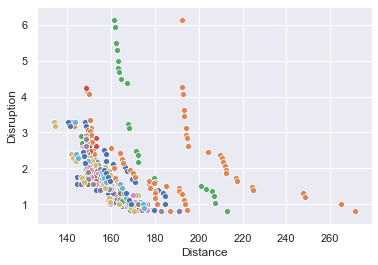

In [69]:
for i in range(num_bricks):
    plot_solutions(all_solutions[i][0],generate_new_D(i),new_V,new_SR=True)

In [70]:
def is_more_efficient(s1, s2, V):
    """
    return true if solution1 is more efficient than solution2
    meaning that disruption(solution1) <= disruption(solution2) and distance(solution1) <= distance(solution2)
    """
    sol1, loc1 = s1
    sol2, loc2 = s2
    D1 = generate_new_D(loc1)
    D2 = generate_new_D(loc2)
    return (compute_total_disruption(sol1, V, new_SR=True) < compute_total_disruption(sol2, V, new_SR=True))\
           and (compute_total_distance(sol1, D1) < compute_total_distance(sol2, D2))

In [71]:
def is_efficient(list_of_sol, sol, V):
    """
    return true if sol is efficient considering list_of_sol
    """
    for other_sol in list_of_sol:
        if other_sol[1] != sol[1]:
            if is_more_efficient(other_sol, sol, V):
                return False
    return True

In [72]:
# We flatten the all_solutions list to obtain a list of tupple
# (solutions, corresponding position of new SR)
all_solutions_flatten = []
for list_sol in all_solutions:
    for sol in list_sol[0]:
        all_solutions_flatten.append((sol, list_sol[1]))
        
# We remove all positions which are not efficient
efficient_solutions_flatten = []
for sol in all_solutions_flatten:
    if is_efficient(all_solutions_flatten, sol, new_V):
        efficient_solutions_flatten.append(sol)

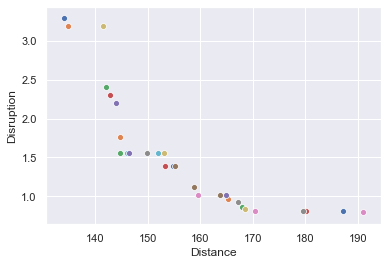

In [73]:
for sol in efficient_solutions_flatten:
    plot_solutions([sol[0]],generate_new_D(sol[1]),new_V,new_SR=True)

### Question 6) 

New variable Wij = 1 if SR j office is located on brick i 
For each j, sum over i Wij = 1 (each SR must have one and only one office)

Now new distance constant variable Bij : is the distance between brick i and brick j 
Let's call Mij, the distance between SR j office and brick i = (Sum over k of Wkj * Dik)
Minimize 
Sum over j,i Xij * Mij 

In [74]:
prev_L = np.zeros((num_bricks, num_SR), dtype=int)
for j in range(num_SR):
    prev_L[structure.loc[j,"Center-brick"]-1, j] = 1
    
def num_of_office_moves(prev_L, new_L):
    return int(np.sum(prev_L * (1 - new_L)))

In [75]:
def generate_CPSAT_model(disrupt_bound=1000, distance_bound=1000, max_moves=4, \
                         min_load=0.8, max_load=1.2, minimize=False):
    
    model = cp_model.CpModel()
    num_bricks = 22
    num_SR = 4
    
    # We need to only have integer number to use CP-SAT
    # Idea, we multiply by 10000
    round_value = 10000
    V = (initial_V * round_value).astype(int)
    B = (initial_B * round_value).astype(int)

    # VARIABLES
    X = {}
    for i in range(num_bricks):
        for j in range(num_SR):
            X[(i,j)] = model.NewBoolVar('X_%i_%i'%(i,j))

    L = {}
    for i in range(num_bricks):
        for j in range(num_SR):
            L[(i,j)] = model.NewBoolVar('L_%i_%i'%(i,j))

    # PARAMETERS 
    min_load = int(min_load * round_value)
    max_load = int(max_load * round_value)
    disrup_up_bound = int(disrupt_bound * round_value)
    distance_bound = int(distance_bound * round_value)

    # CONSTRAINTS

    # each SR is located at one and only one block
    for j in range(num_SR):
        model.Add(sum(L[i,j] for i in range(num_bricks)) == 1)

    #each brick is assigned to one and only one SR 
    for i in range(num_bricks):
        model.Add(sum(X[i,j] for j in range(num_SR)) == 1)

    # disruption 
    disruption = sum((X[i,j] * (1 - P[i,j]) + P[i,j] * (1 - X[i,j])) * V[i] \
                  for i in range(num_bricks) \
                  for j in range(num_SR))
    
    model.Add(disruption <= disrup_up_bound)

    # max moves
    model.Add(sum(L[i,j] * (1 - prev_L[i,j]) for i in range(num_bricks)\
                                             for j in range(num_SR))\
              <= max_moves)
                  
    # workload 
    for j in range(num_SR):
        model.Add(sum(X[i,j] * V[i] for i in range(num_bricks)) <= max_load)
        model.Add(sum(X[i,j] * V[i] for i in range(num_bricks)) >= min_load)

    # distance 
    # B is brick to brick distance
    # The distance between brick i and SR j office = Sum over k Bik * Lkj 
    # Now total distance is sum over i,j (sum over k Bik * Lkj) * Xij 
    # = Sum over i,j,k  Bik * Lkj * Xij 
    # Let us note Kijk = Lkj * Xij, we must linearize this product 
    # To do so, we simply have to write the following constraint 
    #   Kijk >= Lkj + Xij - 1
    #   Kijk <= 1/2 * (Lkj + Xij)
    K = {}
    for i in range(num_bricks):
        for j in range(num_SR):
            for k in range(num_bricks):
                K[(i,j,k)] = model.NewBoolVar('K_%i_%i_%i'%(i,j,k))
                model.Add(K[i,j,k] >= L[k,j] + X[i,j] - 1)
                model.Add(2 * K[i,j,k] <= L[k,j] + X[i,j])

    distance = sum(B[i,k] * K[i,j,k] for i in range(num_bricks)\
                                     for j in range(num_SR)\
                                     for k in range(num_bricks))
    if not minimize:
        model.Add(distance <= distance_bound)   
    
    elif minimize:
        model.Minimize(round_value * distance + disruption)
    
    return model, X, L

In [76]:
def convert_to_matrix(solver, X, L):
    """
    Take as input X and L - CP-SAT variables
    return corresponding numpy_array 
    """
    assignment_matrix = np.zeros((num_bricks, num_SR))
    loc_matrix = np.zeros((num_bricks, num_SR))
    for i in range(num_bricks):
        for j in range(num_SR):
            assignment_matrix[i][j] = solver.Value(X[i,j])
            loc_matrix[i][j] = solver.Value(L[i,j])
    return assignment_matrix, loc_matrix

In [85]:
def find_multiple_solutions(max_moves, epsilon=0.1):
    """
    Same technique as before to find all efficient solutions 
    Note that :
        - we find all efficient solutions for which number of offices moves <= max_moves
        - it is not really efficient solution because we shut down the solver before it reach
            an optimal solution 
            
    Return a list of solutions which contain tupple :
        (assignment_matrix, loc_matrix, num_of_moves, distance, disruption)
    """
    
    continue_to_solve = True
    list_solutions = []
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = 60
    disrupt_bound = 1000
    number_of_solutions = 0
    

    while continue_to_solve:
        sat_model, X_sat_var, L_sat_var = generate_CPSAT_model(disrupt_bound=disrupt_bound,
                                                               max_moves=max_moves, minimize=True)
        status = solver.Solve(sat_model)
        
        if (status == cp_model.FEASIBLE) or (status == cp_model.OPTIMAL):
            number_of_solutions += 1
            new_X, new_L = convert_to_matrix(solver, X_sat_var, L_sat_var)
            num_moves = num_of_office_moves(prev_L, new_L)
            distance = compute_total_distance(new_X, initial_B @ new_L)
            disruption = compute_total_disruption(new_X, initial_V)
            is_optimal = (status == cp_model.OPTIMAL)
            if (is_optimal):
                txt = "(optimal)"
            else:
                txt = "(non-optimal)"
            print("solution n°", number_of_solutions, txt,"num_moves :", num_moves,
                  "distance :", distance, "disruption :", disruption)
            

            
            disrupt_bound = disruption - epsilon 
            list_solutions.append((new_X, new_L, num_moves, distance, disruption, is_optimal))
        else:
            continue_to_solve = False
            
    return list_solutions

In [86]:
list_of_list_solutions = []
for i in range(5):
    print("We allow to have no more than ",i, "moves")
    list_solutions = find_multiple_solutions(max_moves=i, epsilon=0.1)
    list_of_list_solutions.append(list_solutions)

We allow to have no more than  0 moves
solution n° 1 (optimal) num_moves : 0 distance : 154.61522148779602 disruption : 2.411
solution n° 2 (optimal) num_moves : 0 distance : 154.63550188861177 disruption : 2.2454
solution n° 3 (optimal) num_moves : 0 distance : 154.9916006657822 disruption : 1.9934
solution n° 4 (optimal) num_moves : 0 distance : 160.70696672357968 disruption : 1.794
solution n° 5 (optimal) num_moves : 0 distance : 163.3465184773965 disruption : 1.6849999999999998
solution n° 6 (optimal) num_moves : 0 distance : 165.89577680644427 disruption : 1.1728
solution n° 7 (optimal) num_moves : 0 distance : 166.4335254137433 disruption : 0.9992000000000001
solution n° 8 (optimal) num_moves : 0 distance : 168.13304090952204 disruption : 0.8620000000000001
solution n° 9 (optimal) num_moves : 0 distance : 168.89343764710048 disruption : 0.7472000000000001
solution n° 10 (optimal) num_moves : 0 distance : 174.60880370489798 disruption : 0.5478000000000001
solution n° 11 (optimal) 

In [91]:
def convert_to_dataframe(list_of_list_solutions):
    """
    Convert the list of list of solutions to a list a dataframe
    so that it will be easy to plot the solutions 
    """
    list_of_dataframe = []
    
    for list_of_solutions in list_of_list_solutions:
        df = pd.DataFrame(columns=["moves", "distance", "disruption", "optimal"])
        for i, sol in enumerate(list_of_solutions):
            df.loc[i] = sol[2], sol[3], sol[4], sol[5]
        list_of_dataframe.append(df)
        
    return list_of_dataframe

In [92]:
list_df = convert_to_dataframe(list_of_list_solutions)

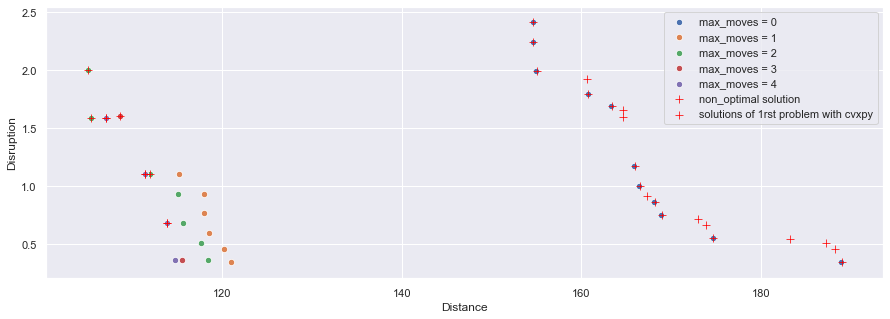

In [167]:
fig = plt.figure(1, figsize=(15, 5))

list_legends = []
for i in range(5):
    sns.scatterplot(x="distance", y="disruption", data=list_df[i], s=40, marker = "o")
    list_legends.append("max_moves = "+str(i))


df = list_df[0]
for i in range(0,4):
    df = pd.concat([df, list_df[i+1]], axis=0)
df_opt = df[df["optimal"] == True]
df_non_opt = df[df["optimal"] == False]
sns.scatterplot(x="distance", y="disruption", marker = "+", s=50, color="red", data=df_non_opt)
list_legends.append("non_optimal solution")
plot_solutions(list_of_solutions_Q1, initial_D)
list_legends.append("solutions of 1rst problem with cvxpy")

#plt.legend(list_legends, title="", loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(list_legends, title="")
